Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

Importing Datasets

In [ ]:
# Load data
trans = pd.read_csv('/transactions_data.csv')

# Load JSON files
with open('/mcc_codes.json', 'r') as f:
    mcc_codes = json.load(f)

# Convert JSON to DataFrames
mcc_df = pd.DataFrame.from_dict(mcc_codes, orient='index').reset_index()
mcc_df.columns = ['mcc', 'merchant_category']  # Rename columns

In [ ]:
# Loading Top-Level Dictionary
# Step 1: Load JSON
with open('/train_fraud_labels.json', 'r') as f:
    raw_data = json.load(f)

# Step 2: Extract the inner dictionary
fraud_labels = raw_data['target']  # this is what contains transaction ID : "No"/"Yes"

# Step 3: Convert to DataFrame
fraud_df = pd.DataFrame.from_dict(fraud_labels, orient='index', columns=['is_fraud']).reset_index()
fraud_df.rename(columns={'index': 'id'}, inplace=True)

# Step 4: Optional – Convert "Yes"/"No" to 1/0
fraud_df['is_fraud'] = fraud_df['is_fraud'].map({'Yes': 1, 'No': 0})

# Step 5: Preview
# print(fraud_df.head())
# fraud_df['is_fraud'].value_counts()

Data Analysis/Pre Processing

MCC Codes

In [5]:
mcc_df.dtypes

,0
mcc,object
merchant_category,object


In [6]:
#Turn mcc into
mcc_df['mcc'] = pd.to_numeric(mcc_df['mcc'])

In [7]:
mcc_df.isnull().sum()

,0
mcc,0
merchant_category,0


Fraud Codes

In [8]:
fraud_df.dtypes

,0
id,object
is_fraud,int64


In [9]:
#Turn fraud_df into int
fraud_df['id'] = pd.to_numeric(fraud_df['id'])

In [10]:
fraud_df.isnull().sum()

,0
id,0
is_fraud,0


Transactions

In [11]:
# Checking for null values
print(trans.shape)
print(trans.isnull().sum())

(13305915, 12)
id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64


In [ ]:
# Checking if correct datatypes are assigned to the columns

nuuniq = []
dtyp = []
uuniq = []

for col in trans.columns:
    nuuniq.append(trans[col].nunique())
    dtyp.append(trans[col].dtype)
    uuniq.append(trans[col].unique()[0])

result = pd.DataFrame({"Column Name": trans.columns, 'Count of Unique values': nuuniq, 'Assigned Datatype': dtyp, 'Value': uuniq})
result

,Column Name,Count of Unique values,Assigned Datatype,Value
0,id,13305915,int64,7475327
1,date,4136496,object,2010-01-01 00:01:00
2,client_id,1219,int64,1556
3,card_id,4071,int64,2972
4,amount,81161,object,$-77.00
5,use_chip,3,object,Swipe Transaction
6,merchant_id,74831,int64,59935
7,merchant_city,12492,object,Beulah
8,merchant_state,199,object,ND
9,zip,25256,float64,58523.0


In [ ]:
# Merge Transactions and MCC codes
trans_fraud = pd.merge(trans, fraud_df, on='id', how='inner')
trans_fraud.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,0
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,0
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,0
3,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,0
4,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,0


In [ ]:
# Merge fraud labels into the merged transaction-MCC dataset
final_df = pd.merge(trans_fraud, mcc_df, on='mcc', how='left')
final_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud,merchant_category
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,0,Miscellaneous Food Stores
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,0,Department Stores
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,0,Money Transfer
3,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,0,Drinking Places (Alcoholic Beverages)
4,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,0,Book Stores


In [ ]:
# Change Amount to int
final_df['amount'] = final_df['amount'].str.replace('$', '')
final_df['amount'] = pd.to_numeric(final_df['amount'])
final_df.rename(columns = {'amount': 'Amount($)'}, inplace = True)

In [ ]:
# Step 2: Creating Absolute Amount feature
final_df['Absolute_Amount'] = final_df['Amount($)'].abs()

In [ ]:
# Extract Date-related features
final_df['date'] = pd.to_datetime(final_df['date'])

# Extract day of the week (0=Monday, 6=Sunday)
final_df['day_of_week'] = final_df['date'].dt.dayofweek

# Extract hour of the day (0 to 23)
final_df['hour_of_day'] = final_df['date'].dt.hour

# Check if the transaction occurred on the weekend (0=Monday, 6=Sunday)
final_df['is_weekend'] = final_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
final_df['Payment_Type'] = np.where(final_df['Amount($)'] < 0, 'Debit', 'Credit')

In [ ]:
# Fill Error Column
final_df['errors'].fillna('Errorless', inplace = True)

In [ ]:
# Filling Merchant State
final_df['merchant_state'].fillna(final_df['merchant_state'].mode()[0], inplace = True)

In [ ]:
# Dropping Zip
final_df.drop(columns=['zip'], inplace=True)

In [ ]:
final_df.head()

,id,date,client_id,card_id,Amount($),use_chip,merchant_id,merchant_city,merchant_state,mcc,errors,is_fraud,merchant_category,Absolute_Amount,day_of_week,hour_of_day,is_weekend,Payment_Type
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,5499,Errorless,0,Miscellaneous Food Stores,77.00,4,0,0,Debit
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,5311,Errorless,0,Department Stores,14.57,4,0,0,Credit
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,4829,Errorless,0,Money Transfer,80.00,4,0,0,Credit
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,5813,Errorless,0,Drinking Places (Alcoholic Beverages),46.41,4,0,0,Credit
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,5942,Errorless,0,Book Stores,4.81,4,0,0,Credit


In [ ]:
print(final_df.isnull().sum())

id                   0
date                 0
client_id            0
card_id              0
Amount($)            0
use_chip             0
merchant_id          0
merchant_city        0
merchant_state       0
mcc                  0
errors               0
is_fraud             0
merchant_category    0
Absolute_Amount      0
day_of_week          0
hour_of_day          0
is_weekend           0
Payment_Type         0
dtype: int64


Encoding

In [12]:
# Encoding Categorical Features using LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# List of categorical columns that need encoding
categorical_columns = ['use_chip', 'merchant_city', 'merchant_state', 'mcc', 'errors', 'merchant_category']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    final_df[col] = label_encoder.fit_transform(final_df[col])


NameError: name 'final_df' is not defined

In [ ]:
# Scaling Numerical Features using StandardScaler
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# List of numerical columns to be scaled
numerical_columns = ['Amount($)', 'Absolute_Amount', 'day_of_week', 'hour_of_day', 'is_weekend']

# Apply StandardScaler to the numerical columns
final_df[numerical_columns] = scaler.fit_transform(final_df[numerical_columns])

In [ ]:
# Step 3: Prepare X (features) and y (target)
X = final_df[['Amount($)', 'Absolute_Amount', 'day_of_week', 'hour_of_day', 'is_weekend',
              'use_chip', 'merchant_city', 'merchant_state', 'mcc', 'errors', 'merchant_category']]

y = final_df['is_fraud']

Splitting data into testing and training

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Check the shapes of the split data
print(f"Training data shape: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test data shape: X_test = {X_test.shape}, y_test = {y_test.shape}")

Training data shape: X_train = (7131970, 11), y_train = (7131970,)
Test data shape: X_test = (1782993, 11), y_test = (1782993,)


Model Creation

In [ ]:
# importing necesaary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict using the logistic regression model
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1-Score: {f1_log_reg:.4f}")  #3mins

Logistic Regression Performance:
Accuracy: 0.9985
Precision: 0.3333
Recall: 0.0023
F1-Score: 0.0045


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train) #12

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

[[1780274      83]
 [    899    1737]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780357
           1       0.95      0.66      0.78      2636

    accuracy                           1.00   1782993
   macro avg       0.98      0.83      0.89   1782993
weighted avg       1.00      1.00      1.00   1782993

ROC AUC Score: 0.9911730188207133


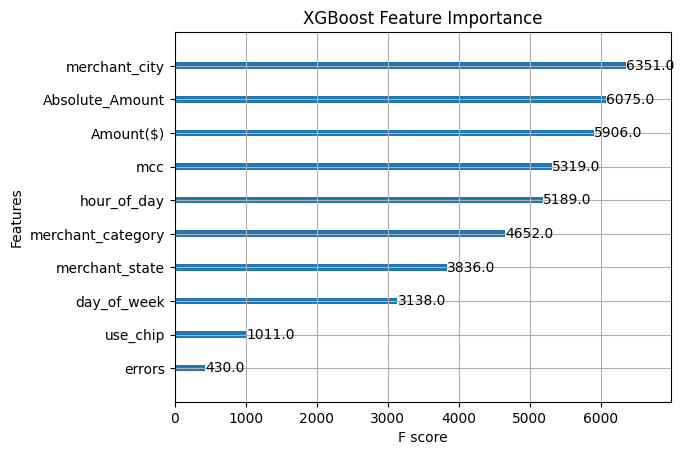

Feature: merchant_city, Importance: 6351.0
Feature: Absolute_Amount, Importance: 6075.0
Feature: Amount($), Importance: 5906.0
Feature: mcc, Importance: 5319.0
Feature: hour_of_day, Importance: 5189.0
Feature: merchant_category, Importance: 4652.0
Feature: merchant_state, Importance: 3836.0
Feature: day_of_week, Importance: 3138.0
Feature: use_chip, Importance: 1011.0
Feature: errors, Importance: 430.0


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.show()

# Display the top features
for feature, importance in importances[:10]:
    print(f'Feature: {feature}, Importance: {importance}')


In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Create and train the LightGBM model
lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8
)

lgbm_model.fit(X_train, y_train)

# Predictions
y_pred = lgbm_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# AUC Score
y_probs = lgbm_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

[LightGBM] [Info] Number of positive: 10696, number of negative: 7121274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.951448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 7131970, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Confusion Matrix:
 [[1729667   50690]
 [    159    2477]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   1780357
           1       0.05      0.94      0.09      2636

    accuracy                           0.97   1782993
   macro avg       0.52      0.96      0.54   1782993
weighted avg       1.00      0.97      0.98   1782993

ROC AUC Score: 0.99057312368

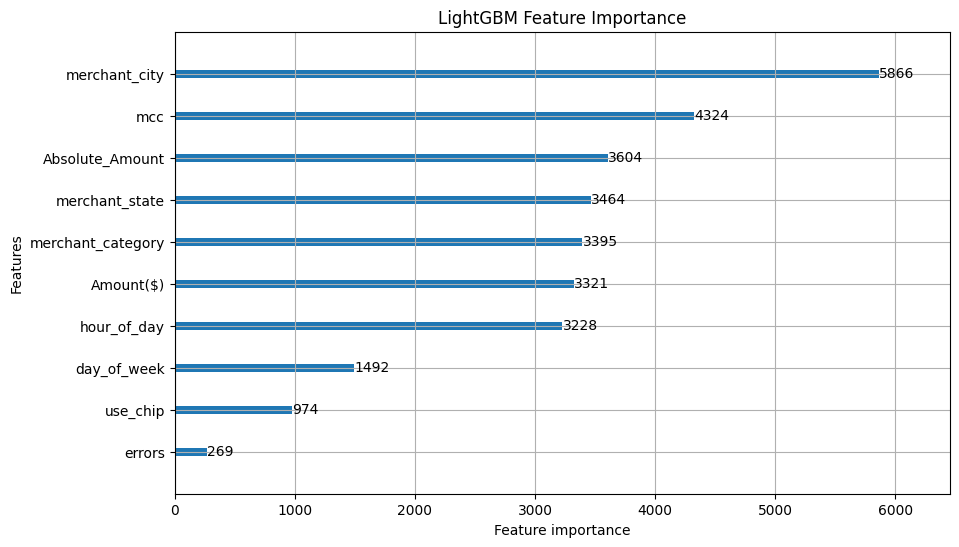

AttributeError: 'LGBMClassifier' object has no attribute 'feature_importance'

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Plot feature importance
lgb.plot_importance(lgbm_model, max_num_features=10, importance_type='split', figsize=(10, 6))
plt.title('LightGBM Feature Importance')
plt.show()

# Display the top features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))
